<a href="https://colab.research.google.com/github/chris-j-weber/MasterThesis/blob/main/Ensemble_%26_End_to_End_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages & load DataSet

In [ ]:
#@title Imports

import keras
from keras.models import Model, Sequential

from keras.layers import LSTM, Dropout, Dense, Input, ConvLSTM2D, BatchNormalization, Flatten, Concatenate
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import plot_model

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
np.random.seed(42)

import tensorflow
tensorflow.random.set_seed(10)

In [ ]:
#@title Load Data
import os
import h5py
import pickle
import gdown

#bist_du_chris = True #@param {type:"boolean"}

if bist_du_chris:
  #from google.colab import drive
  
  textEmbeddingDictPath_avg4hs = '/content/drive/MyDrive/SarcasmDetection/DataSets/Text/mean_last_4hiddenouput_id.pkl'
  textEmbeddingDictPath_hidden = '/content/drive/MyDrive/SarcasmDetection/DataSets/Text/bert_lasthidden_id.pkl'
  textEmbeddingDictPath_pool = '/content/drive/MyDrive/SarcasmDetection/DataSets/Text/bert_pooler_id.pkl'

  audioFeaturesDictPath = '/content/drive/MyDrive/SarcasmDetection/DataSets/Audio_Features/en_utterances_mfccs.pkl'
  video_featuresPath = '/content/drive/MyDrive/SarcasmDetection/DataSets/Video_Features_(MUStARD)/resnet_pool5.hdf5'

else:
  url = 'https://drive.google.com/uc?export=download&id=1meyZOKkZfgt6uF41lxwp8LUnlSzIDd1x'
  output = 'en_utterances_mfccs.pkl'
  gdown.download(url, output, quiet=True)

  # last hidden layer  (finetuned):
  url = 'https://drive.google.com/uc?export=download&id=1onU9KqW65HRoGw2S_S6osHvEVMeoXALd'
  output = 'bert_lasthidden_id.pkl'
  gdown.download(url, output, quiet=True)

  # mean last 4 hidden layer (finetuned)
  url = 'https://drive.google.com/uc?export=download&id=1ZrahsHfwK1q87eZVN7oxuwsTHFgbZs5r'
  output = 'mean_last_4hiddenouput_id.pkl'
  gdown.download(url, output, quiet=True)

  # last pool layer  (finetuned):
  url = 'https://drive.google.com/uc?export=download&id=1IQmLZIcxAnwipwzcFBvRK-u6frGpN_h8'
  output = 'bert_pooler_id.pkl'
  gdown.download(url, output, quiet=True)

  # visual features:
  url = 'https://drive.google.com/uc?export=download&id=1gN0IgpfWFGlxDQDpU-PwBQwahSRzDoTs'
  output = 'resnet_pool5.hdf5'
  gdown.download(url, output, quiet=True)

  # audio features:
  url = 'https://drive.google.com/uc?export=download&id=1meyZOKkZfgt6uF41lxwp8LUnlSzIDd1x'
  output = 'audio_mfccs_engl.pkl'
  gdown.download(url, output, quiet=True)




  textEmbeddingDictPath_hidden = '/content/bert_lasthidden_id.pkl'
  textEmbeddingDictPath_pool = '/content/bert_pooler_id.pkl'
  textEmbeddingDictPath_avg4hs = '/content/mean_last_4hiddenouput_id.pkl'
  
  audioFeaturesDictPath = '/content/audio_mfccs_engl.pkl'
  video_featuresPath = '/content/resnet_pool5.hdf5'


with open(textEmbeddingDictPath_hidden, 'rb') as file:
  textEmbeddingDict_lasthidden = pickle.load(file)

with open(textEmbeddingDictPath_pool, 'rb') as file:
  textEmbeddingDict_pool = pickle.load(file)

with open(textEmbeddingDictPath_avg4hs, 'rb') as file:
  textEmbeddingDict_avg4hs = pickle.load(file)

with open(audioFeaturesDictPath, 'rb') as file:
    audioFeaturesDict = pickle.load(file)
video_features = h5py.File(video_featuresPath)

#Download the pre-extracted BERT features and place the two files directly under the folder data/
if not (os.path.isfile('./data/bert-output-context.jsonl') and os.path.isfile('./data/bert-output.jsonl')):
  !gdown --id 1GYv74vN80iX_IkEmkJhkjDRGxLvraWuZ
  !unzip BERT_text_features.zip -d ./data/
  !rm -rf /content/data/__MACOSX
  !rm -rf /content/BERT_text_features.zip

#original MUStARD audio Features (not used anymore - carefull of different audio input shape):
#!wget https://github.com/soujanyaporia/MUStARD/raw/master/data/audio_features.p
#with open('/content/audio_features.p', 'rb') as file:
#    audioFeaturesDict = pickle.load(file, encoding="latin1")


#load german text dict
url = 'https://drive.google.com/uc?export=download&id=1UUbV65qbg1oAUM1xlgoNrhxgyj2glUy4'
output = 'ger_utterances_mfccs.pkl'
gdown.download(url, output, quiet=True)
ger_text_path = '/content/ger_utterances_mfccs.pkl'
with open(ger_text_path, 'rb') as f:
    df_ger = pickle.load(f)

#load german audio dict
url = 'https://drive.google.com/uc?export=download&id=151sCGrYEnwT4R3ALlCPavIRSSBoyCNVd'
output = 'ger_utterances_mfccs.pkl'
gdown.download(url, output, quiet=True)
gerAudioFeaturesDictPath = '/content/ger_utterances_mfccs.pkl'
with open(gerAudioFeaturesDictPath, 'rb') as file:
    gerAudioFeaturesDict = pickle.load(file)

In [ ]:
#@title Create and split train test set
show_for_test_data = "FRIENDS" #@param ["FRIENDS", "BBT", "GOLDENGIRLS", "SARCASMOHOLICS"]

import os
!git clone -qq https://github.com/chris-j-weber/sarcasmdetection
!mv sarcasmdetection/utils/ utils/
!rm -rf sarcasmdetection

if not os.path.isfile('/content/sarcasm_data.json'):
  !wget -qq https://raw.githubusercontent.com/soujanyaporia/MUStARD/master/data/sarcasm_data.json

from utils.data_reader import *
mustard_path = './sarcasm_data.json'
mustard_data = read_mustard(mustard_path)#.drop(['context'], axis=1)
id_with_label_show = {mustard_data.id[i]: [mustard_data.is_sarcastic[i], mustard_data.show[i]] for i in range(len(mustard_data.id))}

def get_train_test_data(show_for_test):
  train_files, train_labels, val_files, val_labels = [], [], [], []

  for idx, [label, show] in id_with_label_show.items():
    file_path = './landmarks/' + idx + '_landmark.csv'
    #if file_path in file_list:
    if show != show_for_test:
      train_files.append(idx)
      train_labels.append(label)
    else:
      val_files.append(idx)
      val_labels.append(label)
  return train_files, train_labels, val_files, val_labels


train_files, train_labels, val_files, val_labels = get_train_test_data(show_for_test_data)


In [ ]:
#@title Make valid and test set balanced (or not)

make_test_valset_balanced = True #@param {type:"boolean"}

if make_test_valset_balanced:
  # create two list with all indexes of 0 and 1 examples
  valzero = [e for e, f in enumerate(val_labels) if f == 0]
  valone = [e for e, f in enumerate(val_labels) if f == 1]
  
  # cutting lists to of same length
  valzero = valzero[:min([len(valone), len(valzero)])]
  valone = valone[:min([len(valone), len(valzero)])]

  val_balanced_files = []
  val_balanced_labels = []

  # zip val_files in balanced way
  for e, _ in enumerate(valzero):
    val_balanced_files += [val_files[valzero[e]], val_files[valone[e]]]
    val_balanced_labels += [0,1]

  val_files, test_files = val_balanced_files[:int(len(val_balanced_files)/2)], val_balanced_files[int(len(val_balanced_files)/2):]
  val_labels, test_labels = val_balanced_labels[:int(len(val_balanced_labels)/2)], val_balanced_labels[int(len(val_balanced_labels)/2):]
else:
  val_files, test_files = val_files[:int(len(val_files)/2)], val_files[int(len(val_files)/2):]
  val_labels, test_labels = val_labels[:int(len(val_labels)/2)], val_labels[int(len(val_labels)/2):]


def get_label(i):
  return id_with_label_show[i][0]

val_labels = [get_label(i) for i in val_files]
test_labels = [get_label(i) for i in test_files]

In [ ]:
#@title Load MUStARD orignal BERT Embeddings

!pip -qq install jsonlines
import jsonlines

BERT_TARGET_EMBEDDINGS = '/content/data/bert-output.jsonl'

text_mustard_bert_embeddings = {}
with jsonlines.open(BERT_TARGET_EMBEDDINGS) as reader:
    
    # Visit each target utterance
    for i, obj in enumerate(reader):
        CLS_TOKEN_INDEX = 0
        features = obj['features'][CLS_TOKEN_INDEX]

        bert_embedding_target = []
        for layer in [0,1,2,3]:
            bert_embedding_target.append(np.array(features["layers"][layer]["values"]))
        bert_embedding_target = np.mean(bert_embedding_target, axis=0)
        text_mustard_bert_embeddings[mustard_data.id[i]] = np.copy(bert_embedding_target)

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

is_sarcastic        0      1
show                        
BBT             140.0  140.0
FRIENDS         204.0  152.0
GOLDENGIRLS       1.0   39.0
SARCASMOHOLICS    NaN   14.0



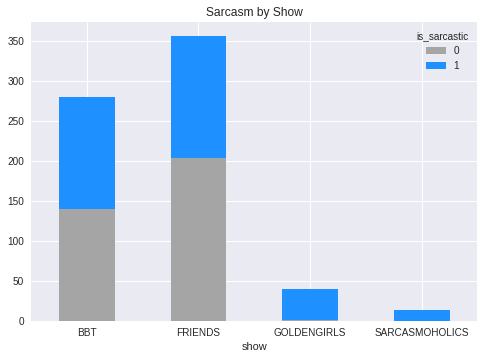

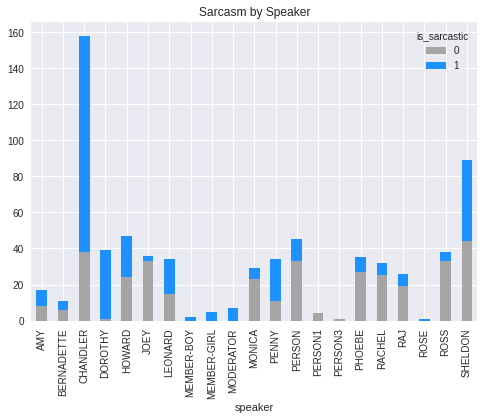

In [ ]:
#@title plot data set
import seaborn as sns
from matplotlib import pyplot as plt


mustard_data2 = mustard_data.groupby(['show', 'is_sarcastic'])['is_sarcastic'].count().unstack()
print(mustard_data2)

def greylist(length):
  cmap = plt.get_cmap('Greys')
  return list(cmap(np.linspace(0.45, 0.85, length)))

colors = greylist(2)
colors[1] = 'dodgerblue' # Swap in a bright blue for the Lacrosse color.

plt.subplot

plt.style.use('seaborn')  #default or seaborn
mustard_data2 = mustard_data.groupby(['show', 'is_sarcastic'])['is_sarcastic'].count().unstack()

mustard_data2.plot(kind='bar', stacked=True, color=colors)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Sarcasm by Show')
plt.xticks(rotation=0, ha='center')


plt.subplot
plt.style.use('seaborn')  #default or seaborn
mustard_data2 = mustard_data.groupby(['speaker', 'is_sarcastic'])['is_sarcastic'].count().unstack()

mustard_data2.plot(kind='bar', stacked=True, color=colors)

# Just add a title and rotate the x-axis labels to be horizontal.
plt.title('Sarcasm by Speaker')
plt.xticks(rotation=90, ha='center')
print()

# ML preprocessing etc.

In [ ]:
#@title DataGenerator
import os
import math
import random
import numpy as np
import pandas as pd

from keras.utils import data_utils


class DataGenerator(data_utils.Sequence):
    """
    Keras Sequence object to train a model on a list of csv files
    """
    def __init__(self, idx_list, labels, visualsfolder, landmarksfolder, audiodict, textdict, resnetfeatures,
                 batch_size, mask=False, shuff=True, uniform=True, text=False, video=False, audio=False, landmarks=False):
        """
        path_to_traindata = path to csv files
        """
        self.idx_list = idx_list                          # list of indexes used for datasets e.g. 1_60, 1_70, ...
        self.labels = labels
        self.batch_size = batch_size
        self.mask = mask
        self.shuffle = shuff
        self.uniform = uniform

        self.text = text
        self.audio = audio
        self.video = video
        self.landmark = landmarks

        self.indexes = np.arange(len(self.idx_list))      # list of integer indexes used for iterating over data sets

        self.visualsfolder = visualsfolder
        self.landmarksfolder = landmarksfolder
        self.audiodict = audiodict
        self.textfeatures = textdict
        self.resnetfeatures = resnetfeatures

        self.max_audio_length = max([self.get_audio_features(i).shape[1] for i in audiodict.keys()])
        self.audio_shape = (self.get_audio_features(idx_list[0]).shape[0], self.max_audio_length)



    def __len__(self):
        return int(math.ceil(len(self.idx_list) / float(self.batch_size)))

    def on_epoch_end(self):
      if self.shuffle == True:
        shuffle(self.indexes)

    def read_csv_func(self, csv_file, colnames):
      return pd.read_csv(csv_file, delimiter=',', names=colnames)

    def random_index_for_label(self, label):
      while True:
        i = np.random.randint(len(self.labels))
        if self.labels[i] == label:
          return i

    def get_index_outof_batch(self, label, batch):
      pass

    def uniform_sample_batch(self, batch):
      batch0 = [i for i in batch if self.labels[i] == 0]
      batch1 = [i for i in batch if self.labels[i] == 1]

      while len(batch0) != len(batch1):
        if len(batch0) < len(batch1):
          i = self.random_index_for_label(0)
          if i not in batch0:
            batch0.append(i)
        elif len(batch0) > len(batch1):
          i = self.random_index_for_label(1)
          if i not in batch1:
            batch1.append(i)

      batch0, batch1 = shuffle(batch0, batch1)
      batch0 = batch0[:int(len(batch)/2)]
      batch1 = batch1[:int(len(batch)/2)]
      batch = shuffle(batch0+batch1)

      return batch

    def get_landmark_sequence(self, idx, landmark_dim=144, seq_max_len=730, random_plus=50):
      file_path = self.landmarksfolder + idx + '_landmark.csv'

      #check if landmarks exsist for landmarks idx
      if os.path.isfile(file_path):
        df = self.read_csv_func(file_path, ['frame', 'landmark'])                                         #read from csv
        sequence = df['landmark']

        # if shuffle is on (training) landmark coordinates are moved
        if not self.shuffle:
          random_plus = np.random.randint(1)
        else:
          random_plus = np.random.randint(random_plus)
        sequence = [np.fromstring(lm[1:-1], np.float32, sep=',')+random_plus for lm in sequence]                      # convert from string

      else:
        sequence = [[]]
      sequence = np.asarray([np.zeros(landmark_dim) if len(l) != landmark_dim else l for l in sequence])  # fill gaps with zeros
      sequence = np.concatenate([np.zeros((seq_max_len-len(sequence), landmark_dim)),sequence])           # pad with zeros to equal len
      return sequence

    def get_landmark_dummy_features(self, landmark_dim=144, seq_max_len=730):
        sequence = np.zeros((seq_max_len, landmark_dim))
        return sequence

    def get_frame_sequence(self, idx, dim=(224, 288, 3), seq_max_len=10):
        file_path = self.visualsfolder + idx + '.csv'
        df = self.read_csv_func(file_path, ['pixels'])                                   #read from csv
        sequence = df['pixels']
        sequence = np.asarray([np.fromstring(seq, np.float32, sep=' ') for seq in sequence])                # convert from string
        
        sequence = sequence[np.random.randint(len(sequence)-seq_max_len):seq_max_len]            #cut random window of seq_max_len
        sequence /= 255
        sequence = sequence.reshape(len(sequence), *dim)
        sequence = np.concatenate([np.zeros((seq_max_len-len(sequence), *dim)), sequence])           # pad with zeros to equal len if sequence is shorter than max len
        return sequence

    def get_random_frame_sequence(self, idx, seq_max_len=10, dim=(224, 288, 3)):
        return np.zeros((seq_max_len, *dim))
    
    def get_resnet_output(self, idx, seq_max_len=480, dim=2048):
        sequence = np.asarray(self.resnetfeatures[idx])
        sequence = np.concatenate([np.zeros((seq_max_len-len(sequence), dim)), sequence])           # pad with zeros to equal len if sequence is shorter than max len
        return sequence
    def get_resnet_dummy_output(self, seq_max_len=480, dim=2048):
        return np.zeros((seq_max_len, dim))

    def get_bert_embeddings(self, idx):
        return self.textfeatures[idx]
    def get_bert_dummy_embeddings(self):
        return np.zeros(768)

    def padAudio(self, instance):
      if instance.shape[1] < self.max_audio_length:
          instance = np.concatenate([instance, np.zeros( (instance.shape[0],(self.max_audio_length-instance.shape[1])))], axis=1)
      return np.array(instance)

    def get_audio_features(self, idx):
        return self.audiodict[idx]

    def get_dummy_audio_features(self):
        return np.zeros(self.audio_shape)

    def get_batch_labels(self, index_list):
        # Fetch a batch of labels
        return np.array([self.labels[i] for i in index_list])
    
    def mask_features(self, features):
        for i in range(len(features[0])):                      # i is batch position
            q = shuffle([n for n in range(len(features))])[0:np.random.randint(len(features))]  # list of positions that will become zeros
            for r in q:
              features[r][i] = 0
        return features

    def get_batch_features2(self, index_list):
        # Fetch a batch of inputs
        text_batch = np.array([self.get_bert_embeddings(self.idx_list[i]) for i in index_list])
        video_batch = np.array([self.get_resnet_output(self.idx_list[i]) for i in index_list])
        audio_batch = np.array([self.padAudio(self.get_audio_features(self.idx_list[i])) for i in index_list])
        features = [text_batch, audio_batch, video_batch]

        return features

    def get_batch_features(self, index_list):
        # Fetch a batch of inputs
        if self.text:
          text_batch = np.array([self.get_bert_embeddings(self.idx_list[i]) for i in index_list])
        else:
          text_batch = np.array([self.get_bert_dummy_embeddings() for i in index_list])

        if self.video:
          video_batch = np.array([self.get_resnet_output(self.idx_list[i]) for i in index_list])
        else:
          video_batch = np.array([self.get_resnet_dummy_output() for i in index_list])

        if self.audio:
          audio_batch = np.array([self.get_audio_features(self.idx_list[i]) for i in index_list])
        else:
          audio_batch = np.array([self.get_dummy_audio_features() for i in index_list])

        if self.landmark:
          landmark_batch = np.array([self.get_landmark_sequence(self.idx_list[i]) for i in index_list])
        else:
          landmark_batch = np.array([self.get_landmark_dummy_features() for i in index_list])
        #frameSequence_batch = np.array([self.get_frame_sequence(self.idx_list[i]) for i in index_list])


        features = [text_batch, audio_batch, video_batch] # landmark_batch

        if self.mask == True:
            features = self.mask_features(features)
        return features

    def __getitem__(self, idx):      
        index_list = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]

        if self.uniform:
          index_list = self.uniform_sample_batch(index_list) 
        batch_x = self.get_batch_features(index_list)
        batch_y = self.get_batch_labels(index_list)
        return batch_x, batch_y

In [ ]:
#@title Early stopping and reduce learning rate during training

early_stopping_monitor = EarlyStopping(monitor='val_accuracy',
                                           min_delta=0,
                                           patience=25,
                                           verbose=0,
                                           mode='auto',
                                           baseline=None,
                                           restore_best_weights=True
                                           )
reduce_lr_loss = ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1,
                                       patience=5,
                                       verbose=0,
                                       mode="auto",
                                       min_delta=0.0001,
                                       cooldown=3,
                                       min_lr=0
                                       )

In [ ]:
#@title ploting
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def getmaxminmeanstd(l):
  lmax = np.max(l, axis=0)
  lmean = np.mean(l, axis=0)
  lmin = np.min(l, axis=0)
  lstd  = np.std(l, axis=0)
  return lmax, lmin, lmean, lstd

def plot_results(results, plottype='default', filename=None, yrange=[0.4,0.8], xrange=None):
  plt.style.use(plottype)
  accuracy_list = []
  val_accuracy_list = []
  loss_list = []
  val_loss_list = []
  for metric in results:
    accuracy_list.append(np.array(metric['accuracy']))
    val_accuracy_list.append(np.array(metric['val_accuracy']))
    loss_list.append(np.array(metric['loss']))
    val_loss_list.append(np.array(metric['val_loss']))

  x = [i for i in range(len(accuracy_list[0]))]
  acc_max, acc_min, acc_mean, acc_std = getmaxminmeanstd(accuracy_list)
  vacc_max, vacc_min, vacc_mean, vacc_std = getmaxminmeanstd(val_accuracy_list)


  plt.clf()
  plt.figure(1)
  fig, ax = plt.subplots()
  #ax.plot(x, acc_mean, '-')
  ax.errorbar(x, acc_mean, acc_std, color='steelblue', alpha=0.7, label='Train Accuracy (Mean ± SD)')
  ax.errorbar(x, vacc_mean, vacc_std, color='darkorange', alpha=0.7, label='Val Accuracy (Mean ± SD)')

  ax.fill_between(x, acc_min, acc_max, alpha=0.1, color='steelblue')
  ax.fill_between(x, vacc_min, vacc_max, alpha=0.1, color='darkorange')
  ax.set_ylim(yrange)

  #ax.plot(x, vacc_mean, '-', label='val acc mean')

  #ax.legend(['1','2','Avg and SD for Train Accuracy', 'Avg and SD for Val Accuracy'])
  ax.legend()
  if filename != None:
    plt.savefig('/content/plots/' + filename)

# ML training

In [ ]:
#@title set text embedding type:
textEmbedding_type = "pool layer (finetuned)" #@param ["mean of last 4 hidden layer (MUStARD)", "mean of last 4 hidden layer (finetuned)", "last hidden layer (finetuned)", "pool layer (finetuned)"]
#set embedding pool layer as embeddings

if textEmbedding_type == "mean of last 4 hidden layer (MUStARD)":
  textEmbeddingDict = text_mustard_bert_embeddings
elif textEmbedding_type == "mean of last 4 hidden layer (finetuned)":
  textEmbeddingDict = textEmbeddingDict_avg4hs
elif textEmbedding_type == "last hidden layer (finetuned)":
    textEmbeddingDict = textEmbeddingDict_lasthidden
elif textEmbedding_type == "pool layer (finetuned)":
  textEmbeddingDict = textEmbeddingDict_pool

In [ ]:
#@title Training Settings
use_text = True #@param {type:"boolean"}
use_audio = True #@param {type:"boolean"}
use_video = True #@param {type:"boolean"}
batch_size = 64 #@param ["32", "64", "128"] {type:"raw"}

uniform_trainset = True #@param {type:"boolean"}
uniform_valset = False #@param {type:"boolean"}
uniform_testset = False #@param {type:"boolean"}

shuffle_trainset = False #@param {type:"boolean"}
shuffle_testset = False #@param {type:"boolean"}


use_feature_mask_on_train = False #@param {type:"boolean"}
use_feature_mask_on_test = False #@param {type:"boolean"}



best_val_accuracy = 0
results = []

predict_size_train = int(np.math.ceil(len(train_files) / batch_size))
predict_size_valid = int(np.math.ceil(len(val_files) / batch_size))
predict_size_test = int(np.math.ceil(len(test_files) / batch_size))

param_file = {
    'visualsfolder':None,
    'landmarksfolder':'/content/landmarks/',
    'audiodict':audioFeaturesDict,
    'textdict':textEmbeddingDict,
    'resnetfeatures':video_features,
    'batch_size':batch_size,
    'text':use_text,
    'audio':use_audio,
    'video':use_video,
    'landmarks':False
    }


train_gen = DataGenerator(idx_list=train_files,
                          labels=train_labels,
                          shuff=shuffle_trainset,
                          uniform=uniform_trainset,
                          mask=use_feature_mask_on_train,
                          **param_file)
val_gen = DataGenerator(idx_list=val_files,
                        labels=val_labels,
                        shuff=shuffle_testset,
                        uniform=uniform_valset,
                        mask=use_feature_mask_on_test,
                        **param_file)
test_gen = DataGenerator(idx_list=test_files,
                        labels=test_labels,
                        shuff=shuffle_testset,
                        uniform=uniform_testset,
                        mask=use_feature_mask_on_test,
                        **param_file)


keras.backend.clear_session() # set weights to default if trained before


In [ ]:
#@title german data generators

ger_param_file = {
    'visualsfolder':None,
    'landmarksfolder':'/content/landmarks/',
    'audiodict':gerAudioFeaturesDict,
    'textdict':textEmbeddingDict,
    'resnetfeatures':video_features,
    'batch_size':batch_size,
    'text':use_text,
    'audio':use_audio,
    'video':use_video
    }


if show_for_test_data == "BBT":
  ger_val_gen = DataGenerator(idx_list=val_files,
                          labels=val_labels,
                          shuff=shuffle_testset,
                          uniform=uniform_valset,
                          mask=use_feature_mask_on_test,
                          **ger_param_file)
  ger_test_gen = DataGenerator(idx_list=test_files,
                          labels=test_labels,
                          shuff=shuffle_testset,
                          uniform=uniform_testset,
                          mask=use_feature_mask_on_test,
                          **ger_param_file)
else:
  print('German Test Set only available with BBT show as Test Set')

German Test Set only available with BBT show as Test Set


In [ ]:
#@title define the number of models per modality
number_of_models = 5 #@param {type:"integer"}

best_models = {'text':[], 'audio':[], 'video':[]}
modalitylist = ['text', 'audio', 'video']

# Text Model

In [ ]:
#@title Build Text Model

def build_text_model(lr, dc=1e-6):

    #Text Input
    xtext = Input(shape=(768), name='TextFeatureInput')
    xt = Sequential()(xtext)
    xt = Dropout(rate=0.6)(xt)
    xt = Dense(16, activation='relu')(xt)
    xt = Dense(8, activation='relu')(xt)
    output = Dense(1, activation='sigmoid', name='text_output')(xt)

    #Video Input
    xvideo = Input(shape=(480, 2048), ragged=False, name='resnetVideoFeatureInput')

    #Audio Input
    audio_shape = (170, 40)
    xaudio = Input(shape=audio_shape, name='AudioFeatureInput')

    model = Model(inputs=[xtext, xaudio, xvideo], outputs=[output], name='TextModel')
  
    optimizer = Adam(learning_rate=lr, decay=dc)   # lr=0.003

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


# Reminder: wenn early_stopping_monitor nicht in callbacks > letztes model wird verwendet, nicht bestes

In [ ]:
#@title Train Text Models
learning_rate = 0.001 #@param {type:"number"}

best_models['text'] = []
text_results = []
overall_text_mean_testacc = []

for i in range(number_of_models):
  keras.backend.clear_session() # set weights to default
  new_model = build_text_model(lr=learning_rate)

  print('Text model', str(i) + ':', 'Accuracy')
  history = new_model.fit(
                      train_gen,
                      steps_per_epoch=predict_size_train,
                      epochs=25,
                      validation_data=val_gen,
                      validation_steps=predict_size_valid,
                      max_queue_size=15,
                      callbacks=[reduce_lr_loss, early_stopping_monitor],
                      verbose=0 # 0 for no output
                      )

  vscore, vacc = new_model.evaluate(val_gen, steps=predict_size_test, verbose=0)
  tscore, tacc = new_model.evaluate(test_gen, steps=predict_size_test, verbose=0)

  print('Valid accuracy:', "%.4f" % vacc)
  print('Test  accuracy:', "%.4f" % tacc)
  print()

  overall_text_mean_testacc.append(tacc)
  text_results.append(history.history)
  best_models['text'].append(new_model)
  print()

Text model 0: Accuracy
Valid accuracy: 0.6382
Test  accuracy: 0.5592


Text model 1: Accuracy
Valid accuracy: 0.6184
Test  accuracy: 0.5592


Text model 2: Accuracy
Valid accuracy: 0.6447
Test  accuracy: 0.5592


Text model 3: Accuracy
Valid accuracy: 0.6316
Test  accuracy: 0.5526


Text model 4: Accuracy
Valid accuracy: 0.6118
Test  accuracy: 0.5526




Test Set: FRIENDS
Embedding Type: pool layer (finetuned)

              precision    recall  f1-score   support

           0      0.605     0.342     0.437        76
           1      0.541     0.776     0.638        76

    accuracy                          0.559       152
   macro avg      0.573     0.559     0.537       152
weighted avg      0.573     0.559     0.537       152

Mean Accuracy on Test Set: 0.5565789461135864


<Figure size 640x480 with 0 Axes>

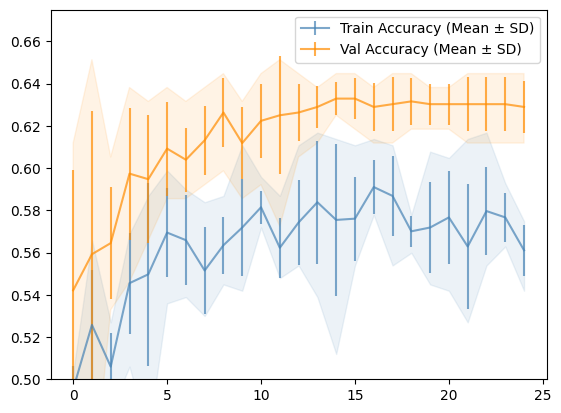

In [ ]:
#@title Evaluation Text Model

text_test_preds = []

textmodel = best_models['text'][1]

text_test_preds = np.round(textmodel.predict(test_gen),0)
#print(text_test_preds)

#y_true = val_gen.labels
text_y_true = test_gen.labels

print('Test Set:', show_for_test_data)
print('Embedding Type:', textEmbedding_type)
print()
print(classification_report(text_y_true, text_test_preds, digits=3))

print('Mean Accuracy on Test Set:', np.mean(overall_text_mean_testacc))

# plot Text Results
plot_results(text_results, yrange=[0.5,0.675])  # for comparison in thesis [0.4, 0.8]
import pickle
picklename = show_for_test_data + '-' + textEmbedding_type.replace(" ", "_") + '.pkl'
with open(picklename, 'wb') as f:
    pickle.dump(text_results, f)


# Audio Model

In [ ]:
from tensorflow.keras import layers


def build_lstm_model(input_shape, lr):
    #Audio Input
    xaudio = Input(shape=input_shape, name='AudioFeatureInput')
    xa = LSTM(128, return_sequences=False, dropout=0.5)(xaudio)
    xa = Dense(32, activation='relu')(xa)
    xa = Dropout(rate=0.5)(xa)
    xa = Dense(16, activation='relu')(xa)
    xa = Dropout(rate=0.5)(xa)
    xa = Dense(8, activation='relu')(xa)
    output = Dense(1, activation='sigmoid', name='combined_output')(xa)

    model = Model(inputs=[xaudio], outputs=[output], name='MultimodalModel')
    optimizer = Adam(learning_rate=lr, decay=1e-3)   # lr=0.003
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def build_rnn_model(input_shape, lr):
    # keras linear stack of layers
    model = tf.keras.Sequential([
        LSTM(128, input_shape=input_shape, dropout=0.5),
        Dense(32, activation='relu', name='dense1'),
        Dropout(rate=0.5),
        Dense(16, activation='relu', name='dense2'),
        Dropout(rate=0.5),
        Dense(1, activation='sigmoid', name='output')
    ])

    optimizer = Adam(lr=lr, decay=1e-3)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


def build_conv_model(input_shape, lr):
    model = tf.keras.Sequential([
        layers.Input(shape=(170, 40, 1), name='input'),
        layers.Conv2D(64, kernel_size=3, activation='relu', name='cond2d-1'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(32, kernel_size=3, activation='relu', name='con2d-2'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation='relu', name='dense'),
        layers.Dropout(0.5),
        layers.Dense(1, name='dense2'),
        layers.Activation("sigmoid")

    ])

    optimizer = Adam(lr=lr, decay=1e-3)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
def build_audio_model(lr, audioshape=(170, 40)):
    #Text Input
    xtext = Input(shape=(768), name='TextFeatureInput')

    #Video Input
    xvideo = Input(shape=(480, 2048), ragged=False, name='resnetVideoFeatureInput')

    #Audio Input
    audio_shape = (170, 40)
    xaudio = Input(shape=audio_shape, name='AudioFeatureInput')
    xa = LSTM(128, return_sequences=False, dropout=0.6)(xaudio) #dropout 0.5
    xa = Dense(32, activation='relu', name='dense1')(xa)
    xa = Dropout(rate=0.7)(xa) #0.25
    xa = Dense(16, activation='relu', name='dense2')(xa)
    xa = Dropout(rate=0.4)(xa) #0.5
    #xa = Dense(8, activation='relu')(xa)
    output = Dense(1, activation='sigmoid', name='audio_output')(xa)

    model = Model(inputs=[xtext, xaudio, xvideo], outputs=[output], name='AudioModel')
  
    optimizer = Adam(learning_rate=lr, decay=1e-3)   # lr=0.003

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
#@title Train Audio Models

learning_rate_audio = 0.001 #@param {type:"number"}

best_models['audio'] = []
overall_mean_testacc = []
overall_mean_valacc = []

audio_results = []
audioshape = test_gen.audio_shape

for i in range(number_of_models):
  keras.backend.clear_session() # set weights to default
  new_model = build_audio_model(lr=learning_rate_audio, audioshape=audioshape)

  print('Audio model', str(i), 'Test Accuracy:')
  history = new_model.fit(
                      train_gen,
                      steps_per_epoch=predict_size_train,
                      epochs=25,
                      validation_data=val_gen,
                      validation_steps=predict_size_valid,
                      max_queue_size=15,
                      callbacks=[reduce_lr_loss, early_stopping_monitor],
                      verbose=0 # 0 for no output
                      )
  
  vscore, vacc = new_model.evaluate(val_gen, steps=predict_size_test, verbose=0)
  tscore, tacc = new_model.evaluate(test_gen, steps=predict_size_test, verbose=0)

  print('Valid accuracy:', "%.4f" % vacc)
  print('Test  accuracy:', "%.4f" % tacc)
  print()

  audio_results.append(history.history)
  overall_mean_testacc.append(tacc)

  best_models['audio'].append(new_model)

Audio model 0 Test Accuracy:
Valid accuracy: 0.5461
Test  accuracy: 0.5789

Audio model 1 Test Accuracy:
Valid accuracy: 0.6184
Test  accuracy: 0.5658

Audio model 2 Test Accuracy:
Valid accuracy: 0.4342
Test  accuracy: 0.4868

Audio model 3 Test Accuracy:
Valid accuracy: 0.6447
Test  accuracy: 0.5987

Audio model 4 Test Accuracy:
Valid accuracy: 0.6316
Test  accuracy: 0.6118



Test Set: FRIENDS
Modality: Audio

              precision    recall  f1-score   support

           0      0.561     0.724     0.632        76
           1      0.611     0.434     0.508        76

    accuracy                          0.579       152
   macro avg      0.586     0.579     0.570       152
weighted avg      0.586     0.579     0.570       152

Mean Accuracy on Test Set: 0.5684210419654846


<Figure size 640x480 with 0 Axes>

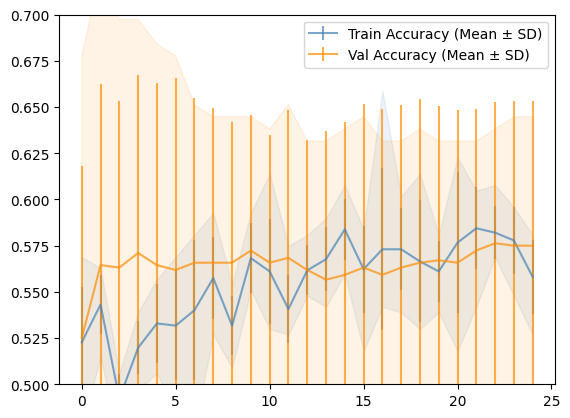

In [ ]:
#@title Evaluation Audio Model

audio_test_preds = []

audiomodel = best_models['audio'][0]

text_y_true = test_gen.labels

audio_test_preds = np.round(audiomodel.predict(test_gen),0)

print('Test Set:', show_for_test_data)
print('Modality: Audio')
print()
print(classification_report(text_y_true, audio_test_preds, digits=3))
print('Mean Accuracy on Test Set:', np.mean(overall_mean_testacc))

# plot Text Results
plot_results(audio_results, yrange=[0.5, 0.7])
import pickle
picklename = show_for_test_data + '-' + 'audio' + '.pkl'
with open(picklename, 'wb') as f:
    pickle.dump(audio_results, f)

# Video Model

In [ ]:
def build_video_model(lr, video_inputshape):

    #Text Input
    xtext = Input(shape=(768), name='TextFeatureInput')

    xaudio = Input(shape=(170, 40), name='AudioFeatureInput')

    #Video Input
    xvideo = Input(shape=video_inputshape, ragged=False, name='resnetVideoFeatureInput')
    xv = LSTM(64, return_sequences=False)(xvideo)
    xv = Dropout(rate=0.8)(xv) #dropout 0.8
    #xv = Dense(16, activation='relu', name='dense2')(xv)
    #xv = Dropout(rate=0.2)(xv)
    output = Dense(1, activation='sigmoid', name='video_output')(xv)


    model = Model(inputs=[xtext, xaudio, xvideo], outputs=[output], name='VideoModel')
  
    optimizer = Adam(learning_rate=lr, decay=1e-6)   # lr=0.001, dc=1e-6

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
#@title Train Video Models
learning_rate_video = 0.001 #@param {type:"number"}

best_models['video'] = []
overall_mean_video_testacc = []

video_results = []
#videoshape = test_gen.audio_shape

for i in range(number_of_models):

  keras.backend.clear_session() # set weights to default if trained before

  video_model = build_video_model(lr=learning_rate_video, video_inputshape=(480, 2048))

  print('Video model', str(i), 'Accuracy:')
  history = video_model.fit(
                      train_gen,
                      steps_per_epoch=predict_size_train,
                      epochs=20,
                      validation_data=val_gen,
                      validation_steps=predict_size_valid,
                      max_queue_size=15,
                      callbacks=[reduce_lr_loss, early_stopping_monitor],
                      verbose=0
                      )
  vscore, vacc = video_model.evaluate(val_gen, steps=predict_size_test, verbose=0)
  tscore, tacc = video_model.evaluate(test_gen, steps=predict_size_test, verbose=0)

  print('Valid accuracy:', "%.4f" % vacc)
  print('Test  accuracy:', "%.4f" % tacc)
  print()

  video_results.append(history.history)
  overall_mean_video_testacc.append(tacc)
  best_models['video'].append(video_model)


Video model 0 Accuracy:
Valid accuracy: 0.5329
Test  accuracy: 0.5132

Video model 1 Accuracy:
Valid accuracy: 0.5197
Test  accuracy: 0.5263

Video model 2 Accuracy:
Valid accuracy: 0.5066
Test  accuracy: 0.4408

Video model 3 Accuracy:
Valid accuracy: 0.5461
Test  accuracy: 0.5329

Video model 4 Accuracy:
Valid accuracy: 0.5066
Test  accuracy: 0.5000



Test Set: FRIENDS
Modality: Video

              precision    recall  f1-score   support

           0      0.470     0.618     0.534        76
           1      0.442     0.303     0.359        76

    accuracy                          0.461       152
   macro avg      0.456     0.461     0.447       152
weighted avg      0.456     0.461     0.447       152

Mean Accuracy on Test Set: 0.48947368264198304


<Figure size 640x480 with 0 Axes>

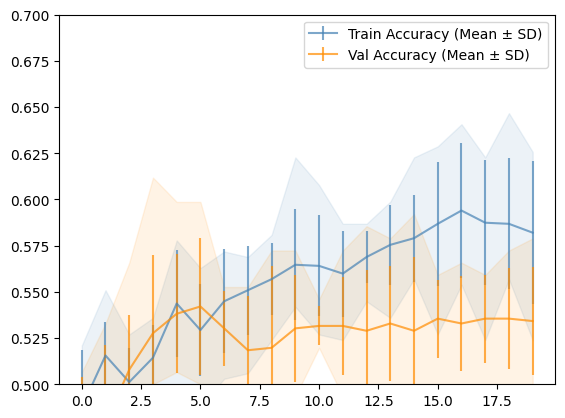

In [ ]:
#@title Evaluation Video Model

video_test_preds = []

videomodel = best_models['video'][0]

text_y_true = test_gen.labels

video_test_preds = np.round(videomodel.predict(test_gen),0)

print('Test Set:', show_for_test_data)
print('Modality: Video')
print()
print(classification_report(text_y_true, video_test_preds, digits=3))
print('Mean Accuracy on Test Set:', np.mean(overall_mean_video_testacc))

# plot Text Results
plot_results(video_results, yrange=[0.5, 0.7])
import pickle
picklename = show_for_test_data + '-' + 'video' + '.pkl'
with open(picklename, 'wb') as f:
    pickle.dump(video_results, f)

## End-to-End Model (Multimodal-Model)

In [ ]:
#@title Build e2e Model

def build_e2e_model():

    #Text Input
    xtext = Input(shape=(768), name='TextFeatureInput')
    xt = Sequential()(xtext)
    xt = Dropout(rate=0.6)(xt)
    xt = Dense(16, activation='relu')(xt)

    #Landmarks Input
    #xlandmarks = Input(shape=(730,144), ragged=False, name='LandmarksFeatureInput')
    #xl = LSTM(144, return_sequences=False, dropout=0.5)(xlandmarks)
    #xl = Dense(32, activation='relu')(xl)
    #xl = Dropout(rate=0.6)(xl)
    #xl = Dense(8, activation='relu')(xl)


    #Video Input
    xvideo = Input(shape=(480, 2048), ragged=False, name='resnetVideoFeatureInput')
    xv = LSTM(32, return_sequences=False)(xvideo)
    xv = Dropout(rate=0.7)(xv)
    xv = Dense(8, activation='relu')(xv)
    #visual_concat = Concatenate(axis=-1, name='VisualConcat')([xv, xl])
    #xv = Dense(16, activation='relu')(visual_concat)
    xv = Dropout(rate=0.5)(xv)

    #Audio Input
    audio_shape = (170, 40)
    xaudio = Input(shape=audio_shape, name='AudioFeatureInput')
    xa = LSTM(128, return_sequences=False, dropout=0.5)(xaudio)
    xa = Dense(32, activation='relu')(xa)
    xa = Dropout(rate=0.25)(xa)
    xa = Dense(16, activation='relu')(xa)
    xa = Dropout(rate=0.5)(xa)

    # Concat Text, Video, Audio
    concat = Concatenate(axis=-1, name='AllConcat')([xt, xa, xv])
    c = Dense(8, activation='relu')(concat)
    output = Dense(1, activation='sigmoid', name='combined_output')(c)


    model = Model(inputs=[xtext, xaudio, xvideo], outputs=[output], name='MultimodalModel')
  
    optimizer = Adam(learning_rate=0.001, decay=1e-6)   # lr=0.003

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

model = build_e2e_model()
model.summary()

Model: "MultimodalModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
AudioFeatureInput (InputLayer)  [(None, 170, 40)]    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          86528       AudioFeatureInput[0][0]          
__________________________________________________________________________________________________
resnetVideoFeatureInput (InputL [(None, 480, 2048)]  0                                            
__________________________________________________________________________________________________
TextFeatureInput (InputLayer)   [(None, 768)]        0                                            
____________________________________________________________________________________

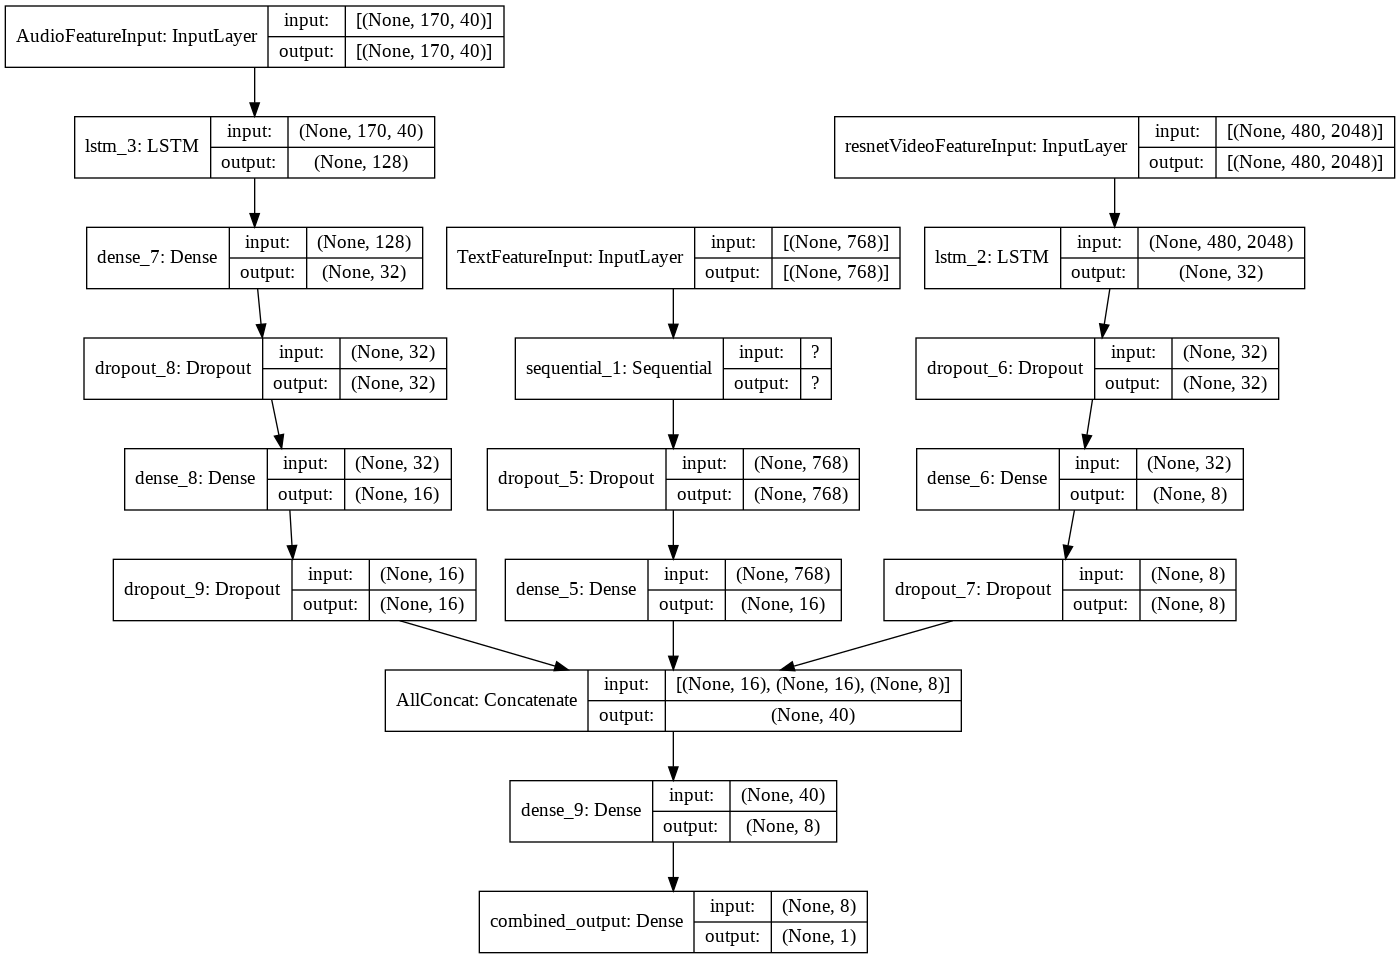

In [ ]:
model = build_e2e_model()
plot_model(model, to_file="model-architecture.png", show_shapes=True)

In [ ]:
#@title Run Training

best_val_accuracy = 0
e2e_results = []
e2e_models = []

#model = build_model()
keras.backend.clear_session() # set weights to default if trained before

for i in range(number_of_models):
  print(str(i+1)+'/'+str(number_of_models))
  keras.backend.clear_session() # set weights to default if trained before
  model = build_e2e_model()
  history = model.fit(
                      train_gen,
                      steps_per_epoch=predict_size_train,
                      epochs=20,
                      validation_data=val_gen,
                      validation_steps=predict_size_valid,
                      max_queue_size=15,
                      callbacks=[reduce_lr_loss, early_stopping_monitor],
                      verbose=0
                      )
  e2e_models.append(model)

  score, vacc = model.evaluate(val_gen, steps=predict_size_test, verbose=0)
  test_score, tacc = model.evaluate(test_gen, steps=predict_size_test, verbose=0)

  print('Valid accuracy:', "%.4f" % vacc)
  print('Test  accuracy:', "%.4f" % tacc)
  print()

  metrics = history.history
  e2e_results.append(metrics)


1/5
Valid accuracy: 0.6579
Test  accuracy: 0.6118

2/5
Valid accuracy: 0.5526
Test  accuracy: 0.5197

3/5
Valid accuracy: 0.6053
Test  accuracy: 0.5921

4/5
Valid accuracy: 0.6645
Test  accuracy: 0.6184

5/5
Valid accuracy: 0.5658
Test  accuracy: 0.5000



<Figure size 640x480 with 0 Axes>

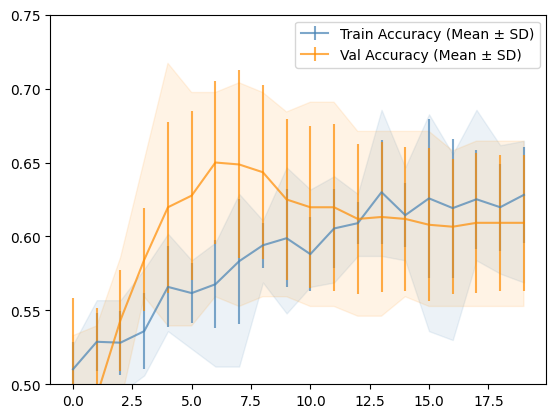

In [ ]:
#@title Evaluation e2e Model


# plot Text Results
plot_results(e2e_results, yrange=[0.5, 0.75])
import pickle
picklename = show_for_test_data + '-' + 'e2e' + '.pkl'
with open(picklename, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#@title save e2e-models

import os
modelpath = '/content/e2e/'
if not os.path.isdir(modelpath):
  os.makedirs(modelpath)

for i, model in enumerate(e2e_models):
  modelname = 'e2e'+ str(i+1)
  model.save(modelpath + modelname + '.h5')

# Ensemble Model (VotingClassifier)

Hard voting choose the label predicted most often by classifiers.

Soft voting, average probabilities predicted by classifiers and choose the label having the highest.

In [ ]:
#@title load pretrained unimodal models (trained with FRIENDS as Test Set)
load_pretrained_models = True #@param {type:"boolean"}

if load_pretrained_models == True:
  url = 'https://drive.google.com/uc?export=download&id=1mEbMuqdE1Do37rbbTYzFbKpGIvdcuTal'
  output = 'unimodal_models_FriendsTestSet.zip'
  gdown.download(url, output, quiet=True)
  !unzip /content/unimodal_models_FriendsTestSet.zip -d /content/

  best_models = {'text':[], 'audio':[], 'video':[]}
  ensemble_model_path = '/content/unimodal_models_FriendsTestSet/'

  for f in sorted(os.listdir(ensemble_model_path)):
    mtype = f[:-4]
    loadedm = keras.models.load_model(ensemble_model_path + '/' + f)
    best_models[mtype].append(loadedm)

Archive:  /content/unimodal_models_FriendsTestSet.zip
   creating: /content/unimodal_models_FriendsTestSet/
  inflating: /content/unimodal_models_FriendsTestSet/audio1.h5  
  inflating: /content/unimodal_models_FriendsTestSet/audio2.h5  
  inflating: /content/unimodal_models_FriendsTestSet/audio3.h5  
  inflating: /content/unimodal_models_FriendsTestSet/audio4.h5  
  inflating: /content/unimodal_models_FriendsTestSet/audio5.h5  
  inflating: /content/unimodal_models_FriendsTestSet/text1.h5  
  inflating: /content/unimodal_models_FriendsTestSet/text2.h5  
  inflating: /content/unimodal_models_FriendsTestSet/text3.h5  
  inflating: /content/unimodal_models_FriendsTestSet/text4.h5  
  inflating: /content/unimodal_models_FriendsTestSet/text5.h5  
  inflating: /content/unimodal_models_FriendsTestSet/video1.h5  
  inflating: /content/unimodal_models_FriendsTestSet/video2.h5  
  inflating: /content/unimodal_models_FriendsTestSet/video3.h5  
  inflating: /content/unimodal_models_FriendsTestSet

In [ ]:
#@title select modality to use in ensemble model:

text_modality = True #@param {type:"boolean"}
audio_modality = True #@param {type:"boolean"}
video_modality = True #@param {type:"boolean"}

modalitylist = []

if text_modality:
  modalitylist.append('text')
if audio_modality:
  modalitylist.append('audio')
if video_modality:
  modalitylist.append('video')

In [ ]:
# evaluation
best_scores = {'text':[], 'audio':[], 'video':[]}
best_test_scores = {'text':[], 'audio':[], 'video':[]}


for mtype in modalitylist:
  print('Validation accuracy for:', mtype)
  for model in best_models[mtype]:
    score, acc = model.evaluate(val_gen, steps=predict_size_valid)
    best_scores[mtype].append(acc)

print()
for mtype in modalitylist:
  print('Test accuracy for:', mtype)
  for model in best_models[mtype]:
    score, acc = model.evaluate(test_gen, steps=predict_size_valid)
    best_test_scores[mtype].append(acc)

Validation accuracy for: text
3/3 [==============================] - 1s 306ms/step - loss: 0.6709 - accuracy: 0.6184
Validation accuracy for: audio
3/3 [==============================] - 1s 301ms/step - loss: 0.6633 - accuracy: 0.6316
Validation accuracy for: video
3/3 [==============================] - 1s 276ms/step - loss: 0.6871 - accuracy: 0.5658

Test accuracy for: text
3/3 [==============================] - 1s 297ms/step - loss: 0.6859 - accuracy: 0.5526
Test accuracy for: audio
3/3 [==============================] - 1s 295ms/step - loss: 0.6736 - accuracy: 0.6118
Test accuracy for: video
3/3 [==============================] - 1s 275ms/step - loss: 0.6895 - accuracy: 0.5132


In [ ]:
#Make predictions for Test Set with loaded Models

val_preds = []
test_preds = []

for mtype in modalitylist:
  for model in best_models[mtype]:
    val_preds.append(model.predict(val_gen))
    test_preds.append(model.predict(test_gen))
y_true = val_gen.labels
test_y_true = test_gen.labels

In [ ]:
#Make predictions for German Audio (if BBT is Test Set)
if show_for_test_data == "BBT":
  ger_val_preds = []
  ger_test_preds = []

  for mtype in modalitylist:
    for model in best_models[mtype]:
      ger_val_preds.append(model.predict(ger_val_gen))
      ger_test_preds.append(model.predict(ger_test_gen))
  ger_y_true = ger_val_gen.labels
  ger_test_y_true = ger_test_gen.labels

In [ ]:
featurenames = []
for mtype in modalitylist:
  for i, model in enumerate(best_models[mtype]):
    featurenames.append(mtype+str(i+1))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report


clf = RandomForestClassifier(n_estimators=7,
                             max_depth= 2,
                             random_state=0)

# concat features (SVM can only read 1D Feature Input)
val_pred_concat = np.concatenate(val_preds, axis=1)
test_concat = np.concatenate(test_preds, axis=1)

clf = clf.fit(val_pred_concat, y_true)

acc = clf.score(test_concat, test_y_true)
#print(acc)

y_pred_rfc = clf.predict(test_concat)

result_string = classification_report(test_y_true, y_pred_rfc, digits=4)
print(confusion_matrix(test_y_true, y_pred_rfc))
print(result_string)

[[48 28]
 [23 53]]
              precision    recall  f1-score   support

           0     0.6761    0.6316    0.6531        76
           1     0.6543    0.6974    0.6752        76

    accuracy                         0.6645       152
   macro avg     0.6652    0.6645    0.6641       152
weighted avg     0.6652    0.6645    0.6641       152



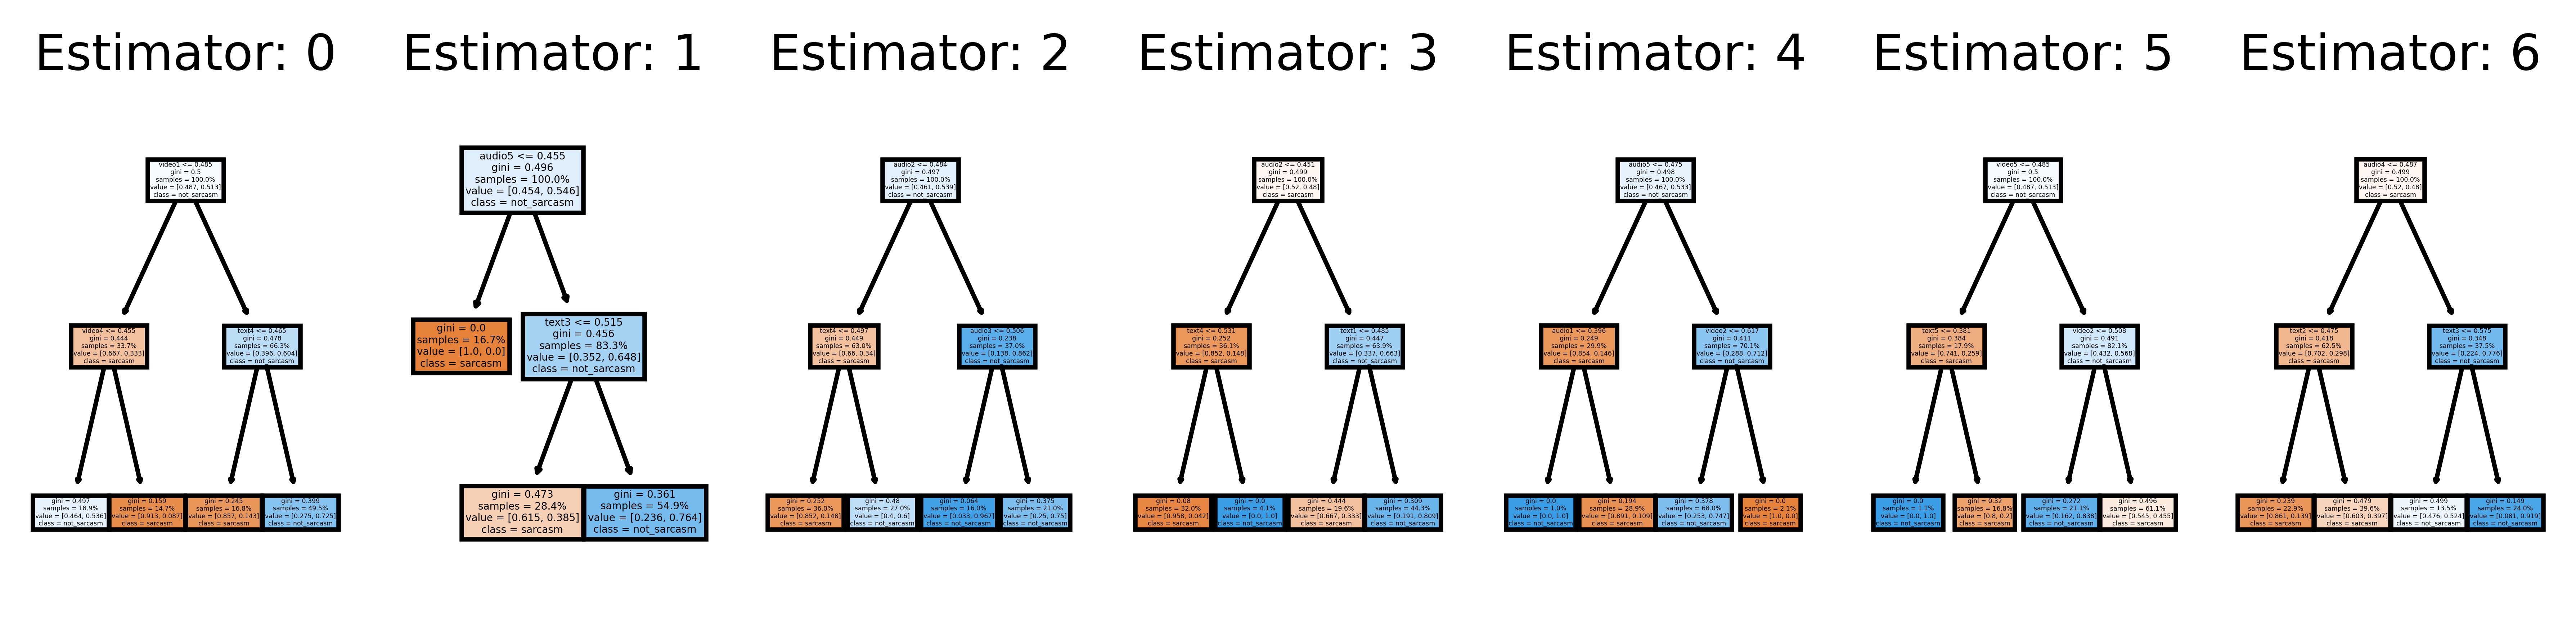

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 7,figsize = (10,2), dpi=900)
for index in range(0, 7):
    tree.plot_tree(clf.estimators_[index],
                   feature_names = featurenames, 
                   class_names=['sarcasm', 'not_sarcasm'],
                   filled = True,
                   #impurity=False,
                   proportion=True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

# Gini index measures the probability of a particular variable being wrongly classified when it is randomly chosen.


In [ ]:
def ensemble(preds, weights):
  #soft weighting
  preds = np.sum(np.concatenate(np.array(preds), axis=1) * np.array(([weights]*len(preds[0]))), axis=1)/sum(weights)
  return preds


def evaluate_ensemble(preds, y_true, weights):
  preds = ensemble(preds, weights)
  y_pred = np.round(preds)
  result_string = classification_report(y_true, y_pred, digits=4, output_dict=True)
  res = result_string['accuracy']
  return res

In [ ]:
#!pip install scipy==1.6.1   # if differential_evolution not working 

from numpy.linalg import norm
from scipy.optimize import differential_evolution

# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result


# loss function for optimization process, designed to be minimized
def loss_function(weights, val_preds, y_true):
	# normalize weights
	normalized = normalize(weights)
	# calculate error rate
	return 1.0 - evaluate_ensemble(val_preds, y_true, weights)


print('Equal Weights - Val  Accuracy: %.4f' % evaluate_ensemble(val_preds, y_true, [1 for _ in range(len(val_preds))]))
print('Equal Weights - Test Accuracy: %.4f' % evaluate_ensemble(test_preds, test_y_true, [1 for _ in range(len(test_preds))]))
print()

# define bounds on each weight
bound_w = [(0.0, 1.0)  for _ in range(len(val_preds))]
weights = [1.0/len(val_preds) for _ in range(len(val_preds))]

# arguments to the loss function
search_arg = (val_preds, y_true)
# global optimization of ensemble weights


import multiprocessing as mp
pool = mp.Pool(4)  # existing worker pool
result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-6, updating='deferred', workers=pool.map)
# get the chosen weights

weights = normalize(result['x'])
print('Optimized Weights: %s' % list(weights))
# evaluate chosen weights

#score = evaluate_ensemble(val_preds, y_true, weights)
print('Optimized Weights - Val Accuracy: %.4f' % evaluate_ensemble(val_preds, y_true, weights))
print('Optimized Weights - Test Accuracy: %.4f' % evaluate_ensemble(test_preds, test_y_true, weights))

Equal Weights - Val  Accuracy: 0.6579
Equal Weights - Test Accuracy: 0.5658

Optimized Weights: [0.027194928350012176, 0.09380894831993916, 0.13118916457876198, 0.07779298473355155, 0.015363362097089247, 0.05243779596377047, 0.1292919500644404, 0.00016670118803043834, 0.08808693161853356, 0.037142838197471925, 0.050004717409010906, 0.043473662878308186, 0.06212119683743692, 0.07188799108725447, 0.12003682667638857]
Optimized Weights - Val Accuracy: 0.7171
Optimized Weights - Test Accuracy: 0.5855


In [ ]:
# load some good learned weights

if load_pretrained_models == True:
  url = 'https://drive.google.com/uc?export=download&id=1j_n1_TpW0enqINqhEgC9npuPRjx0Lohn'
  output = 'optimal_weights.json'
  gdown.download(url, output, quiet=True)

import json
with open('/content/optimal_weights.json') as json_file:
    weights = json.load(json_file)

In [ ]:
# print classification report for predicted samples with optimized weights

y_pred = ensemble(test_preds, weights=weights)
y_pred = np.round(y_pred)

result_string = classification_report(test_y_true, y_pred, digits=4)
print(confusion_matrix(test_y_true, y_pred))
print(result_string)

[[50 26]
 [32 44]]
              precision    recall  f1-score   support

           0     0.6098    0.6579    0.6329        76
           1     0.6286    0.5789    0.6027        76

    accuracy                         0.6184       152
   macro avg     0.6192    0.6184    0.6178       152
weighted avg     0.6192    0.6184    0.6178       152



In [ ]:
optimized_weights = weights
print(optimized_weights)

[0.02230691 0.00814366 0.19663057 0.08320074 0.00987125 0.00108815
 0.21119485 0.00089176 0.00687151 0.24494884 0.00058662 0.03167784
 0.07101069 0.07282844 0.03874817]


In [ ]:
#@title Scores on German Audio (if BBT is Test Set)

if show_for_test_data == "BBT":
  print('Test Score with equal weights: %.4f' % evaluate_ensemble(ger_test_preds, ger_test_y_true, [1 for _ in range(len(ger_test_preds))]))
  ger_test_score = evaluate_ensemble(ger_test_preds, ger_test_y_true, weights)
  print('Test Score with optimized weights: %.4f' % ger_test_score)
else:
  print('German Test Score only available for the BBT Test Set')

German Test Score only available for the BBT Test Set


In [ ]:
#@title save unimodal-models

import os
modelpath = '/content/unimodal_models/'
if not os.path.isdir(modelpath):
  os.makedirs(modelpath)

for mtype in modalitylist:
  for i, model in enumerate(best_models[mtype]):
    modelname = mtype+ str(i+1)
    model.save(modelpath + modelname + '.h5')

In [ ]:
#text
t_val = val_preds[:5]
t_test = test_preds[:5]

#audio
a_val = val_preds[5:10]
a_test = test_preds[5:10]

#video
v_val = val_preds[10:]
v_test = test_preds[10:]

#text-audio
ta_val = val_preds[:10]
ta_test = test_preds[:10]

#text-video
tv_val = val_preds[:5]+val_preds[10:]
tv_test = test_preds[:5]+test_preds[10:]

#audio-video
av_val = val_preds[5:]
av_test = test_preds[5:]

val_y = y_true
test_y = test_y_true

In [ ]:
#!pip install scipy==1.6.1   # if differential_evolution not working 
from scipy.optimize import differential_evolution
from numpy.linalg import norm

def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result


# loss function for optimization process, designed to be minimized
def loss_function(weights, val_preds, y_true):
	# normalize weights
	normalized = normalize(weights)
	# calculate error rate
	return 1.0 - evaluate_ensemble(val_preds, y_true, weights)

def voting(vp, vy, tp, ty, modalities=''):
  print(modalities)
  print('Equal Weights - Val  Accuracy: %.4f' % evaluate_ensemble(vp, vy, [1 for _ in range(len(vp))]))
  print('Equal Weights - Test Accuracy: %.4f' % evaluate_ensemble(tp, ty, [1 for _ in range(len(tp))]))
  print()

  # define bounds on each weight
  bound_w = [(0.0, 1.0)  for _ in range(len(vp))]
  weights = [1.0/len(vp) for _ in range(len(vp))]

  # arguments to the loss function
  search_arg = (vp, vy)
  # global optimization of ensemble weights


  import multiprocessing as mp
  pool = mp.Pool(4)  # existing worker pool
  result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-6, updating='deferred', workers=pool.map)
  # get the chosen weights

  weights = normalize(result['x'])
  print('Optimized Weights: %s' % list(weights))
  # evaluate chosen weights

  #score = evaluate_ensemble(vp, vy, weights)
  print('Optimized Weights - Val Accuracy: %.4f' % evaluate_ensemble(vp, vy, weights))
  print('Optimized Weights - Test Accuracy: %.4f' % evaluate_ensemble(tp, ty, weights))
  print()


  y_pred = ensemble(tp, weights=weights)
  y_pred = np.round(y_pred)
  result_string = classification_report(ty, y_pred, digits=4)
  print(confusion_matrix(ty, y_pred))
  print(result_string)

In [ ]:
#text
voting(t_val, val_y, t_test, test_y, modalities='text')

#audio
voting(a_val, val_y, a_test, test_y, modalities='audio')

#video
voting(v_val, val_y, v_test, test_y, modalities='video')



#text-audio
voting(ta_val, val_y, ta_test, test_y, modalities='text-audio')

#text-video
voting(tv_val, val_y, tv_test, test_y, modalities='text-video')

#audio-video
voting(av_val, val_y, av_test, test_y, modalities='audio-video')


text
Equal Weights - Val  Accuracy: 0.6184
Equal Weights - Test Accuracy: 0.5724

Optimized Weights: [0.21143946369157546, 0.0901976990786897, 0.3990792643365483, 0.2941658760717605, 0.00511769682142618]
Optimized Weights - Val Accuracy: 0.6579
Optimized Weights - Test Accuracy: 0.5724

[[34 42]
 [23 53]]
              precision    recall  f1-score   support

           0     0.5965    0.4474    0.5113        76
           1     0.5579    0.6974    0.6199        76

    accuracy                         0.5724       152
   macro avg     0.5772    0.5724    0.5656       152
weighted avg     0.5772    0.5724    0.5656       152

audio
Equal Weights - Val  Accuracy: 0.6184
Equal Weights - Test Accuracy: 0.5987

Optimized Weights: [0.4242779069775428, 0.049518441210122194, 0.013775106397478388, 0.0797029071830837, 0.4327256382317728]
Optimized Weights - Val Accuracy: 0.6776
Optimized Weights - Test Accuracy: 0.5987

[[60 16]
 [45 31]]
              precision    recall  f1-score   support

 

## Eval e2e Model

In [ ]:
e2e_val_preds = []
e2e_test_preds = []

for e2emodel in e2e_models:
  e2e_val_preds.append(e2emodel.predict(val_gen))
  e2e_test_preds.append(e2emodel.predict(test_gen))
y_true = val_gen.labels
test_y_true = test_gen.labels

val_y = y_true
test_y = test_y_true

In [ ]:
voting(e2e_val_preds, val_y, e2e_test_preds, test_y, modalities='e2e')

e2e
Equal Weights - Val  Accuracy: 0.6053
Equal Weights - Test Accuracy: 0.5724

Optimized Weights: [0.1902538083661644, 0.19718486038836322, 0.0007945318451971721, 0.599096992967864, 0.012669806432411097]
Optimized Weights - Val Accuracy: 0.7171
Optimized Weights - Test Accuracy: 0.6118

[[45 31]
 [28 48]]
              precision    recall  f1-score   support

           0     0.6164    0.5921    0.6040        76
           1     0.6076    0.6316    0.6194        76

    accuracy                         0.6118       152
   macro avg     0.6120    0.6118    0.6117       152
weighted avg     0.6120    0.6118    0.6117       152

